# Data Wrangling

In [1]:
#importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
#Loading the csv files into dataframes
df_users = pd.read_csv('takehome_users.csv', encoding='latin-1')
df_user_engagement = pd.read_csv('takehome_user_engagement.csv')

In [3]:
#Inspecting the first few rows of both dataframes
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
df_user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
#Get the data type in each column, for both dataframes
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
df_user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [7]:
#Casting the 'creation_time' of df_users column as datetime objects
df_users['creation_time'] = pd.to_datetime(df_users['creation_time'])

#Casting the 'time_stamp' column of df_user_engagement as datetime objects
df_user_engagement['time_stamp'] = pd.to_datetime(df_user_engagement['time_stamp'])

#Imputing missing values in the 'last_session_creation_time' column with the mean of that column
df_users['last_session_creation_time'].fillna(df_users['last_session_creation_time'].mean(),inplace=True)

Next, we need to figure out which users have adopted the service. We'll do this in a 2-step process. The first step is to group df_user_engagement by the user_id, and for each user_id we make a list of all the timestamps for that particular user (sorted in time). This will require writing a customized aggregating function:

In [8]:
def sort_the_column(column):
    return sorted(column)

df_aggregated_by_user_id = df_user_engagement.groupby('user_id').agg({
    'time_stamp': sort_the_column})
df_aggregated_by_user_id.head(10)

,time_stamp
user_id,
1,[2014-04-22 03:53:30]
2,"[2013-11-15 03:45:04, 2013-11-29 03:45:04, 201..."
3,[2013-03-19 23:14:52]
4,[2013-05-22 08:09:28]
5,[2013-01-22 10:14:20]
6,[2013-12-19 03:37:06]
7,[2012-12-20 13:24:32]
10,"[2013-01-16 22:08:03, 2013-01-22 22:08:03, 201..."
11,[2013-12-27 03:55:54]


The second step is to figure out, for each of the lists of timestamps in the dataframe above, whether the list contains 3 consecutive timestamps within a 7-day period:

In [9]:
def active_user(list_of_timestamps):
    n = len(list_of_timestamps)
    if n < 3:
        return False
    else:
        for i in range(n-2):
            if (pd.to_datetime(list_of_timestamps[i+2]) - pd.to_datetime(list_of_timestamps[i])).days <= 7:
                return True
        return False

In [10]:
df_aggregated_by_user_id['active'] = df_aggregated_by_user_id['time_stamp'].apply(active_user)
df_aggregated_by_user_id = df_aggregated_by_user_id.drop(columns = ['time_stamp'])
df_aggregated_by_user_id.head()

,active
user_id,
1,False
2,True
3,False
4,False
5,False


Next, we'll join together the dataframes df_users and df_aggregated_by_user_id on the column object_id in the first dataframe and user_id in the latter dataframe. We'll choose a left join because there will be records in df_users which are not in df_aggregated_by_user_id, because some users might not have logged in even once.

In [11]:
combined_df = df_users.merge(df_aggregated_by_user_id, left_on='object_id', right_on='user_id', how='left')
combined_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,False


The column 'active' will now have a few missing values, which we will fill in as False (because those missing values correspond to users in df_users which are not found in df_user_engagement, so such users never logged in and are therefore not active users).

In [12]:
combined_df['active'].fillna(False, inplace=True)

We now do some feature engineering. From the 'creation_time' column, we create two new columns containing the creation month and year.

In [13]:
combined_df['creation_month'] = pd.Categorical(combined_df['creation_time'].dt.month)
combined_df['creation_year'] = pd.Categorical(combined_df['creation_time'].dt.year)

Similarly for the 'last_session_creation_time' column.

In [14]:
combined_df['last_session_creation_month'] = pd.Categorical([datetime.fromtimestamp(stamp).month 
                                                             for stamp in combined_df['last_session_creation_time']])
combined_df['last_session_creation_year'] = pd.Categorical([datetime.fromtimestamp(stamp).year 
                                                            for stamp in combined_df['last_session_creation_time']])

We'll now drop a few columns.

In [15]:
combined_df.drop(columns=['object_id','creation_time','name','email','last_session_creation_time','org_id','invited_by_user_id'], inplace=True)
combined_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,active,creation_month,creation_year,last_session_creation_month,last_session_creation_year
0,GUEST_INVITE,1,0,False,4,2014,4,2014
1,ORG_INVITE,0,0,True,11,2013,3,2014
2,ORG_INVITE,0,0,False,3,2013,3,2013
3,GUEST_INVITE,0,0,False,5,2013,5,2013
4,GUEST_INVITE,0,0,False,1,2013,1,2013


# EDA

Now we do EDA. We will count the number of occurrences of each value for a few columns, and make bar charts.

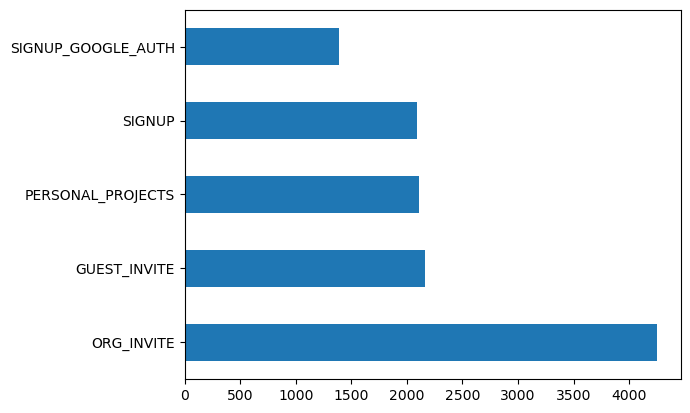

In [16]:
combined_df['creation_source'].value_counts().plot(kind='barh')
plt.show()

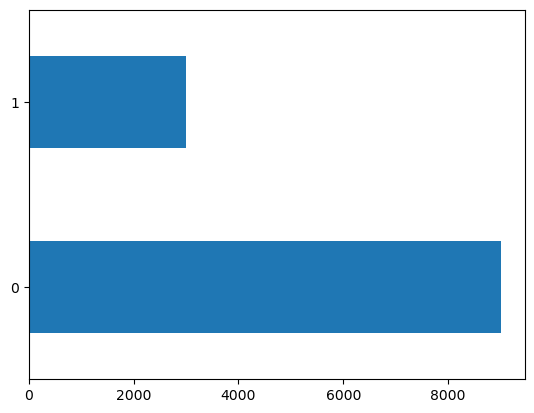

In [17]:
combined_df['opted_in_to_mailing_list'].value_counts().plot(kind='barh')
plt.show()

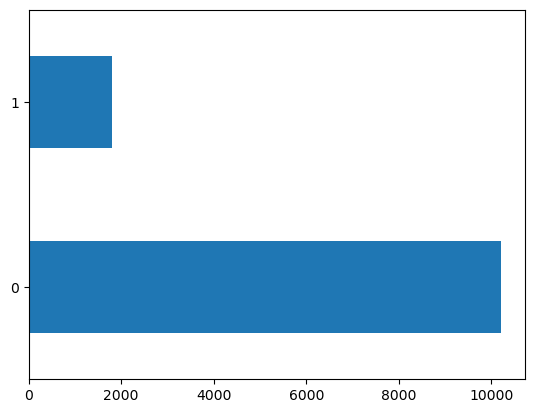

In [18]:
combined_df['enabled_for_marketing_drip'].value_counts().plot(kind='barh')
plt.show()

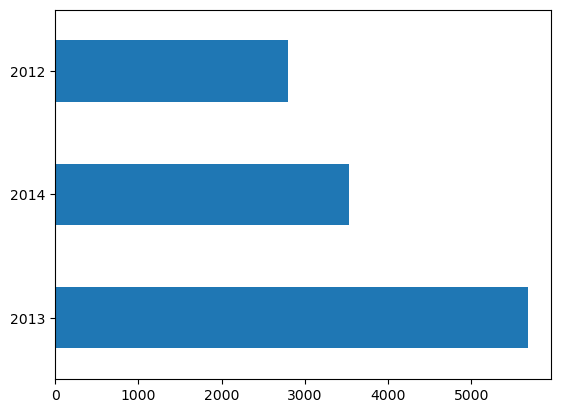

In [19]:
combined_df['creation_year'].value_counts().plot(kind='barh')
plt.show()

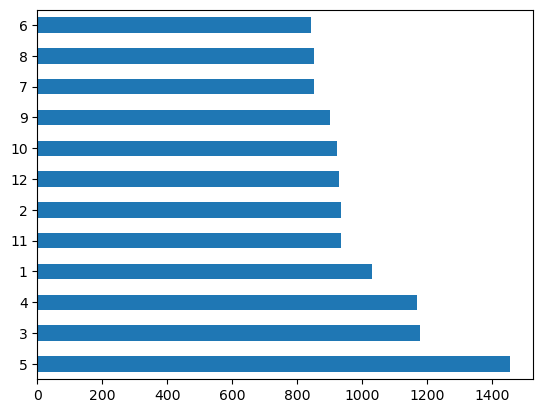

In [20]:
combined_df['creation_month'].value_counts().plot(kind='barh')
plt.show()

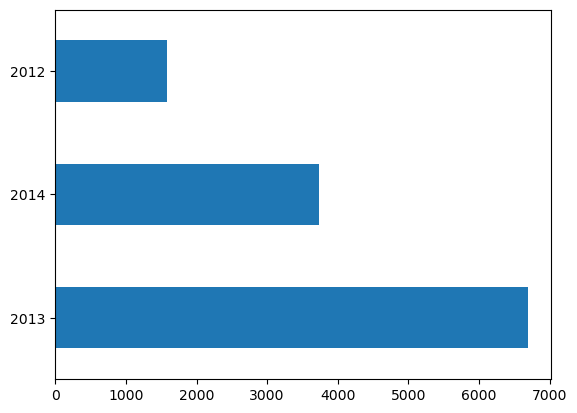

In [21]:
combined_df['last_session_creation_year'].value_counts().plot(kind='barh')
plt.show()

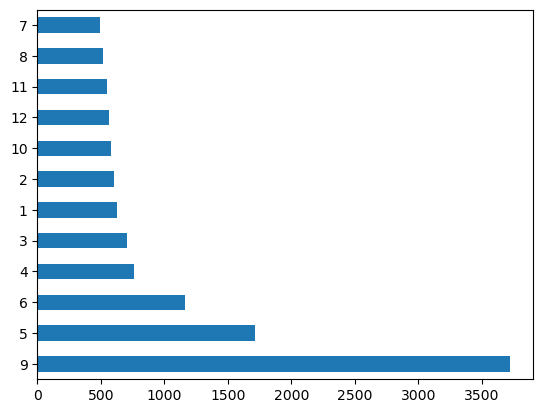

In [22]:
combined_df['last_session_creation_month'].value_counts().plot(kind='barh')
plt.show()

# Pre-processing

In [23]:
#Defining X and Y, and using one-hot encoding for the categorical columns

X = pd.get_dummies(combined_df.drop(columns=['active']))
Y = combined_df['active']

In [24]:
X.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,creation_month_1,creation_month_2,creation_month_3,...,last_session_creation_month_6,last_session_creation_month_7,last_session_creation_month_8,last_session_creation_month_9,last_session_creation_month_10,last_session_creation_month_11,last_session_creation_month_12,last_session_creation_year_2012,last_session_creation_year_2013,last_session_creation_year_2014
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [25]:
Y.head()

0    False
1     True
2    False
3    False
4    False
Name: active, dtype: bool

In [26]:
#Doing train-test split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size = 0.75, random_state = 13)
print(Xtrain.shape, Xtest.shape, Ytrain.shape, Ytest.shape)

(9000, 37) (3000, 37) (9000,) (3000,)


In [27]:
#Scaling the data
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

# Modelling

In [31]:
logreg = LogisticRegression(solver = 'liblinear')
parameters = {"C": [0.001,0.01,0.1]}
cv = GridSearchCV(logreg, param_grid=parameters, scoring='f1', cv=3, 
                 n_jobs=-1)

In [32]:
cv.fit(Xtrain_scaled, Ytrain)
print(cv.best_score_)
print(cv.best_params_)

0.8320690322836448
{'C': 0.1}


In [33]:
Ypred = cv.predict(Xtest_scaled)
print("F1-score of the test set:", f1_score(Ytest, Ypred))

F1-score of the test set: 0.8934426229508197


Finally, we print out the coefficients of each feature.

In [47]:
coefficients = cv.best_estimator_.coef_
coefficients

array([[ 2.14068473e-02,  4.69460331e-02,  8.39946135e-02,
         1.39490175e-02, -5.53771236e-02, -5.42473207e-02,
         7.91999093e-03,  6.60458841e-01,  4.79905059e-01,
         4.17150545e-01,  1.35911709e-03, -5.72361944e-01,
        -8.21797764e-02, -2.43611673e-02,  3.77096592e-02,
         9.06027705e-02, -2.71973723e-01, -2.78656681e-01,
        -4.28254820e-01,  1.94279432e+00,  3.66956149e-01,
        -2.20286255e+00, -4.31068956e-01, -3.08616158e-01,
        -2.95742268e-01,  6.67244836e-03,  7.30818605e-01,
         6.27491561e-01,  1.92037551e-01,  7.65148654e-02,
        -1.16187020e+00,  3.87918901e-01,  3.92233304e-01,
         5.32172134e-01, -1.87150300e+00, -7.22985889e-01,
         2.13653883e+00]])

The above is an array of 37 coefficients, corresponding to the 37 columns of X. Let's look for the position of the largest coefficient (in absolute terms, so ignoring the minus sign).

In [52]:
np.argmax(abs(coefficients))

21

Let's find out which column of X is the column with index 21:

In [55]:
X.columns[21]

'creation_year_2014'

This makes some sense, because 2014 is the most recent year among the 3 values of creation_year. The more recently an account was created, the more likely it is that the user is still active.

Now let's look at array 'coefficients' again, and let's look for the largest coefficient, this time without taking the absolute value:

In [56]:
np.argmax(coefficients)

36

This is the last column of X, which turns out to be:

In [57]:
X.columns[36]

'last_session_creation_year_2014'

So, the more recent a user's last log-in is, the more likely the user is to be active. Again, this makes some sense.